In [ ]:
import os
import datetime
import math
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import ewtpy
import joblib

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

In [ ]:
# DATA
df1 = pd.read_csv('data/data_day.csv')
df2 = pd.read_csv('data/data_2018-08-05_2021-04-30.csv')
df3 = pd.read_csv('data/data_2018-05-05_2018-08-04.csv')
df4 = pd.read_csv('data/data_2015-08-09_2018-05-04.csv')
df5 = pd.read_csv('data/data_2013-02-12_2015-08-08.csv')
df6 = pd.read_csv('data/data_2010-05-19_to_2013-02-11.csv')
df7 = pd.read_csv('data/data_2007-08-23_to_2010-05-18.csv')
df8 = pd.read_csv('data/data_2004-11-26_to_2007-08-22.csv')
# df_test = pd.read_csv('Hanoi 2024-01-22 to 2024-05-01.csv')
df = pd.concat([df6, df5, df4, df3, df2, df1])
df.index = range(0,len(df))
df.tail()
date_time = pd.concat([pd.to_datetime(df['datetime'][0:4000]),pd.to_datetime(df['datetime'][4000:])])
data_use = df[['temp','tempmax', 'tempmin','humidity', 'precip', 'windspeed', 'solarradiation', 'solarenergy']]

print(data_use)

In [ ]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)
timestamp_s[1] - timestamp_s[0]

In [ ]:
# PERIOD TIME

day = 24*60*60
year = (365.2425)*day
# df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
# df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
data_use['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
data_use['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

# plt.plot(np.array(df['Year sin'])[:366])
plt.plot(np.array(data_use['Year cos'])[:])
plt.xlabel('Time [day]')
plt.title('Time of year signal')
data_use.columns

In [ ]:
fft = tf.signal.rfft(data_use['temp'])
f_per_dataset = np.arange(0, len(fft))

n_samples_day = len(data_use['humidity'])
days_per_year = 365.2524
years_per_dataset = n_samples_day/(days_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 40000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [114]:
num_mode = 16
def decompose_to_ewt(data):
    temp_data,  mfb ,boundaries = ewtpy.EWT1D(data, N = num_mode)
    return temp_data, mfb, boundaries
def split_mode(ewt):
    modes = []*num_mode
    for i in range(num_mode):
        modes[i] = [m for m in ewt[:,i]]
    return modes

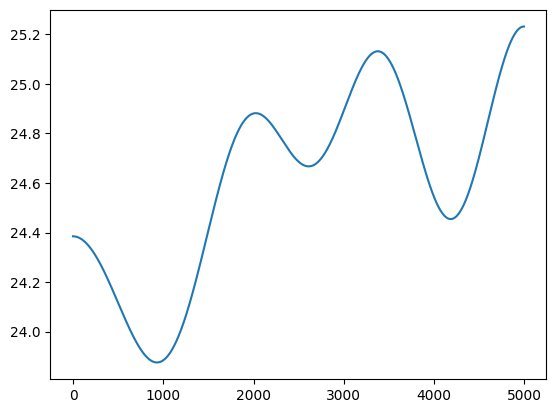

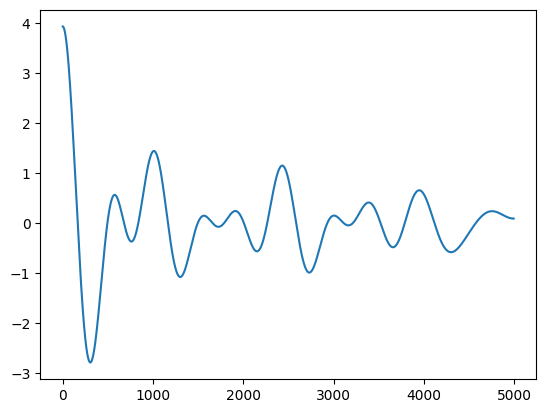

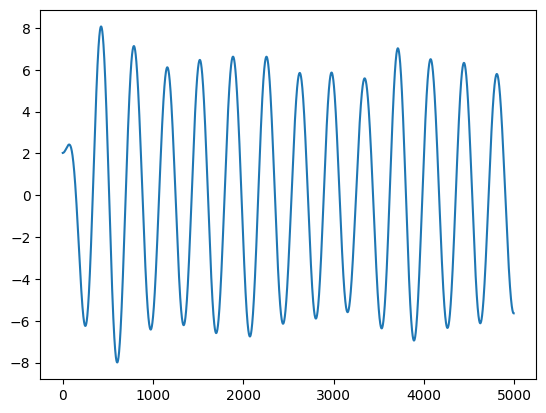

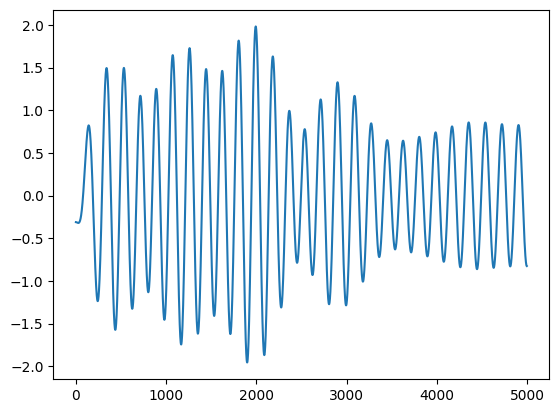

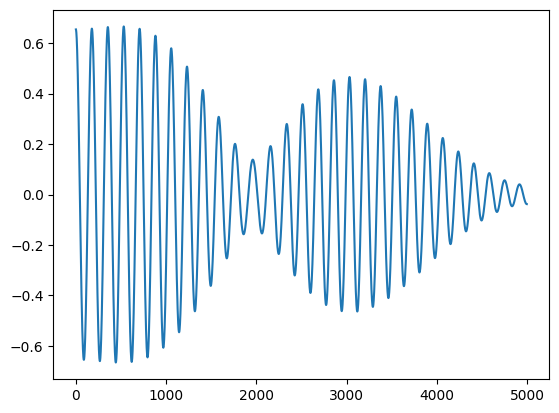

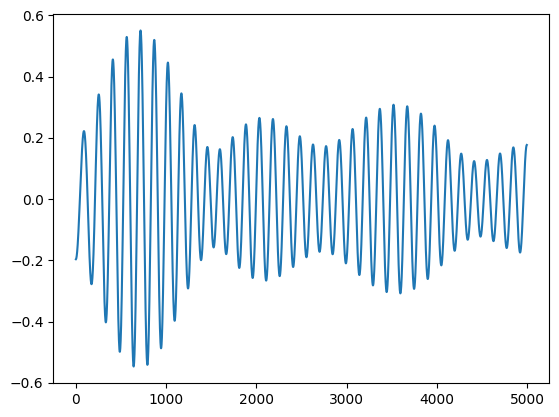

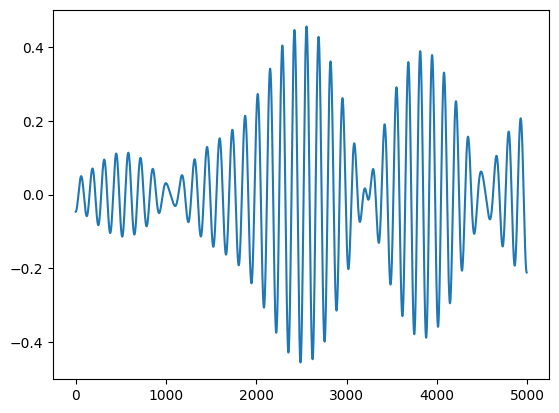

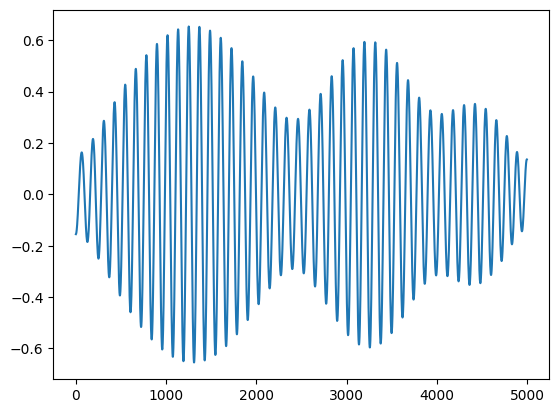

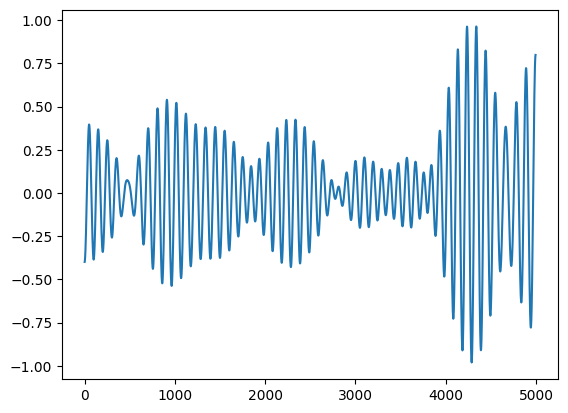

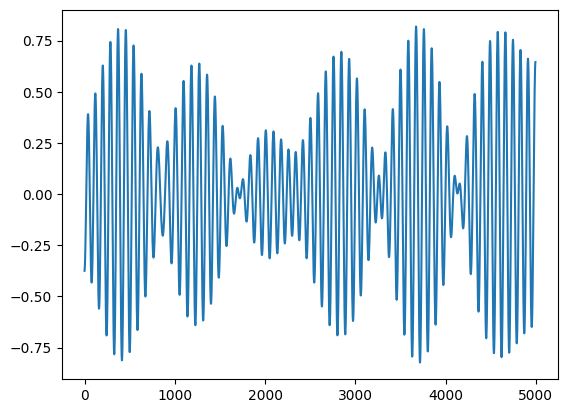

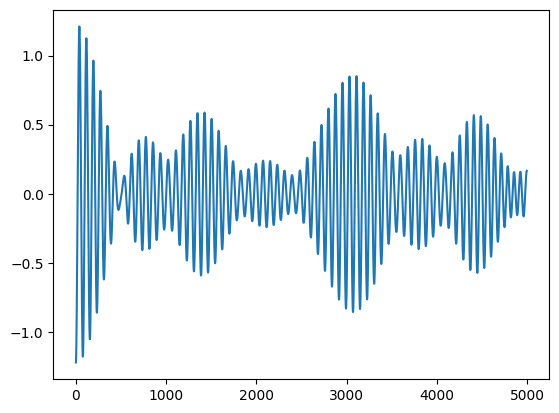

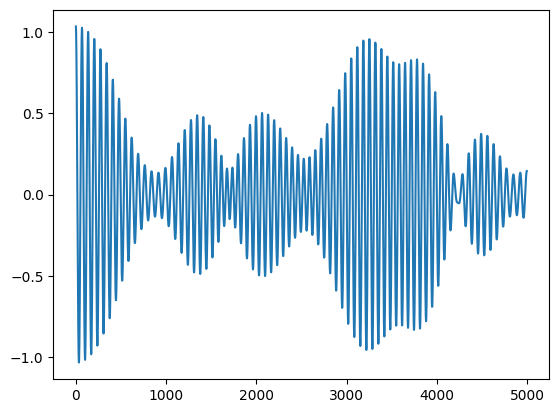

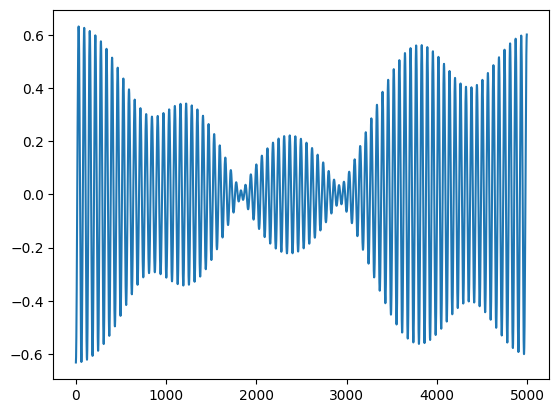

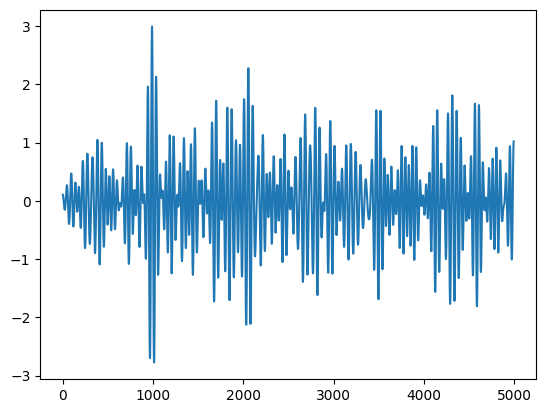

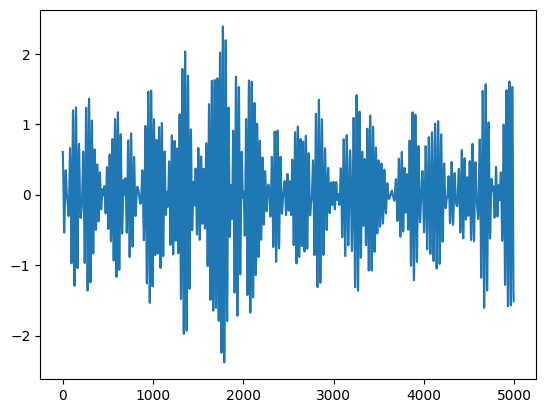

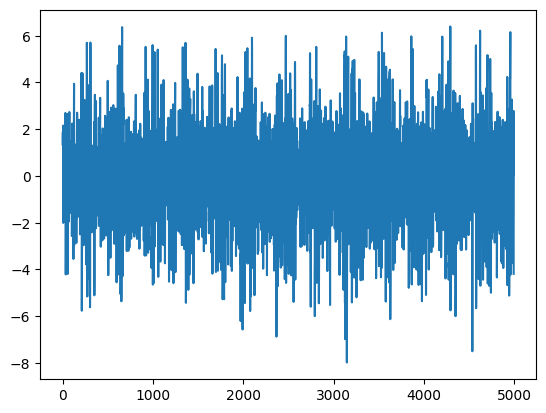

(4996, 16)


In [115]:
temp_ewt,_,_ = decompose_to_ewt(data_use['temp'])
for i in range(num_mode):
    plt.plot(temp_ewt[:,i])
    plt.show()
print(temp_ewt.shape) 

In [116]:
temp_ewt_transpose = np.transpose(temp_ewt)
for i in range(num_mode):
    data_use['temp_ewt'+str(i)] = temp_ewt_transpose[i]

C:\Users\tridu\AppData\Local\Temp\ipykernel_22372\3408805903.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_use['temp_ewt'+str(i)] = temp_ewt_transpose[i]
C:\Users\tridu\AppData\Local\Temp\ipykernel_22372\3408805903.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_use['temp_ewt'+str(i)] = temp_ewt_transpose[i]
C:\Users\tridu\AppData\Local\Temp\ipykernel_22372\3408805903.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [117]:
data_use.columns

Index(['temp', 'tempmax', 'tempmin', 'humidity', 'precip', 'windspeed',
       'solarradiation', 'solarenergy', 'Year sin', 'Year cos', 'temp_ewt0',
       'temp_ewt1', 'temp_ewt2', 'temp_ewt3', 'temp_ewt4', 'temp_ewt5',
       'temp_ewt6', 'temp_ewt7', 'temp_ewt8', 'temp_ewt9', 'temp_ewt10',
       'temp_ewt11', 'temp_ewt12', 'temp_ewt13', 'temp_ewt14', 'temp_ewt15'],
      dtype='object')

In [ ]:
# number_train = int(data_use.shape[0] * 0.8)
# train, test = data_use[0:number_train], data_use[number_train:]

In [118]:
def create_data(in_steps, out_steps, data, features):
    X = []
    y = []
    for i in range(len(data)-in_steps-out_steps + 1):
        X.append(data[i:i+in_steps])
        y.append(data[i+in_steps:i+in_steps+out_steps][features])
    return np.array(X), np.array(y)
def normalize(data, train_mean, train_std):
    data_norm = (data - train_mean)/train_std
    return data_norm
def unnormalize(data, train_mean, train_std):
    data_unnorm = (data * train_std) + train_mean
    return data_unnorm


In [119]:
number_train = int(data_use.shape[0] * 0.8)
train, test = data_use[0:number_train], data_use[number_train:]

In [120]:
in_steps = 365
out_steps = 7
features_train = ['temp']
num_features = len(features_train) 

In [121]:
X_train, y_train = create_data(in_steps, out_steps, train, features_train)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], num_features)

X_test, y_test = create_data(in_steps, out_steps, test, features_train)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], num_features)

X_train_norm = normalize(X_train, X_train.mean(), X_train.std())
y_train_norm = normalize(y_train, y_train.mean(), y_train.std())

X_test_norm = normalize(X_test, X_train.mean(), X_train.std())
y_test_norm = normalize(y_test, y_train.mean(), y_train.std())

print(X_train_norm.shape, y_train_norm.shape, X_test_norm.shape, y_test_norm.shape)

(3625, 365, 26) (3625, 7, 1) (629, 365, 26) (629, 7, 1)


In [188]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(out_steps*num_features),
    tf.keras.layers.Reshape([out_steps, num_features])
])



In [175]:
# Định nghĩa lớp SliceLayer
class SliceLayer(tf.keras.layers.Layer):
    def __init__(self, start, stop, **kwargs):
        super(SliceLayer, self).__init__(**kwargs)
        self.start = start
        self.stop = stop

    def call(self, inputs):
        return inputs[:, self.start:self.stop, :]

    def get_config(self):
        config = super(SliceLayer, self).get_config()
        config.update({'start': self.start, 'stop': self.stop})
        return config

# Sử dụng lớp SliceLayer trong mô hình
CONV_WIDTH = 5

model = tf.keras.Sequential([
    # Sử dụng SliceLayer để cắt tensor
    SliceLayer(start=-CONV_WIDTH, stop=None),
    # Shape => [batch, CONV_WIDTH, features]
    tf.keras.layers.Conv1D(64, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Dense(out_steps*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Reshape([out_steps, num_features])
    # Shape => [batch, out_steps, features]
])

# Đảm bảo thay thế `# số bước đầu ra mong muốn` và `# số đặc trưng` bằng các giá trị thực tế


In [189]:
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Lion(learning_rate = 0.001),
)

In [190]:
history = model.fit(X_train_norm, y_train_norm, epochs=30, validation_split=0.2, batch_size=32, validation_batch_size=32)

Epoch 1/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - loss: 0.9395 - val_loss: 0.3258
Epoch 2/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - loss: 0.2879 - val_loss: 0.2580
Epoch 3/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 0.2505 - val_loss: 0.2324
Epoch 4/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 0.2378 - val_loss: 0.2161
Epoch 5/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 0.2156 - val_loss: 0.1959
Epoch 6/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - loss: 0.2052 - val_loss: 0.1835
Epoch 7/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 0.1876 - val_loss: 0.1780
Epoch 8/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 0.1751 - val_loss: 0.1879
Epoch 9/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 0.1653 - val_loss: 0.1921
Epoch 10/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - loss: 0.1582 - val_loss: 0.1675
Epoch 11/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - loss: 0.1494 - val_loss: 0.1508
Epoch 12/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 10

In [191]:
model.evaluate(X_test_norm, y_test_norm)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0892


0.0986086055636406

In [192]:
model_name = "FINAL_LSTM_EWT_365_7.keras"


In [193]:
model.save(f"model_final/{model_name}")

In [186]:
model_recall_CNN = tf.keras.models.load_model(f"model_final/{model_name}", custom_objects={'SliceLayer': SliceLayer})

In [194]:
model_recall = tf.keras.models.load_model(f"model_final/{model_name}")

In [196]:
print(model_recall.evaluate(X_test_norm, y_test_norm))
print(model_recall_CNN.evaluate(X_test_norm, y_test_norm))

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0892
0.0986086055636406
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1171 
0.12868723273277283


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Day:  1
MAE:  0.9936573283281918
MSE:  1.6890393151783478
CORR:  0.961941474365229
Day:  2
MAE:  1.3000460383622938
MSE:  2.7579179965076372
CORR:  0.9376364628967352
Day:  3
MAE:  1.39713768799847
MSE:  3.1308475494142014
CORR:  0.9308834843453349
Day:  4
MAE:  1.4354504231997247
MSE:  3.3561008099900564
CORR:  0.928234566746248
Day:  5
MAE:  1.4746749274491884
MSE:  3.672044246553037
CORR:  0.9203308045185531
Day:  6
MAE:  1.5434020968802593
MSE:  4.0101738879022975
CORR:  0.9125553781536573
Day:  7
MAE:  1.5910235843142946
MSE:  4.419818667854031
CORR:  0.9019471306242292


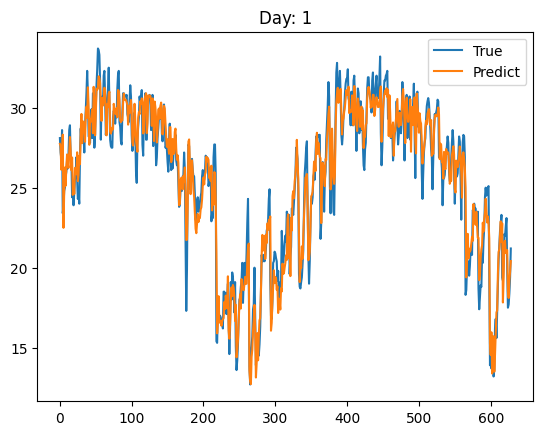

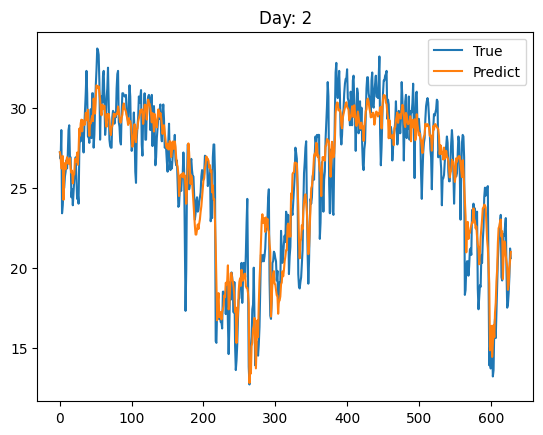

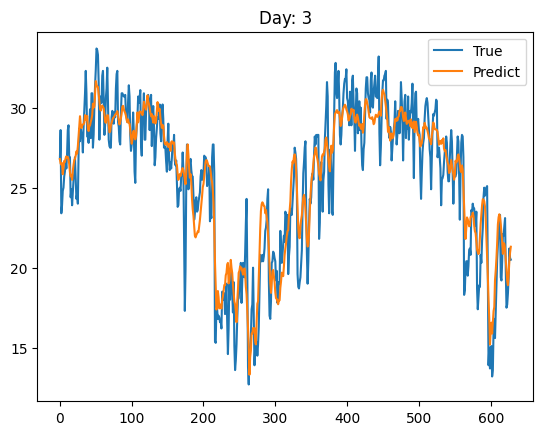

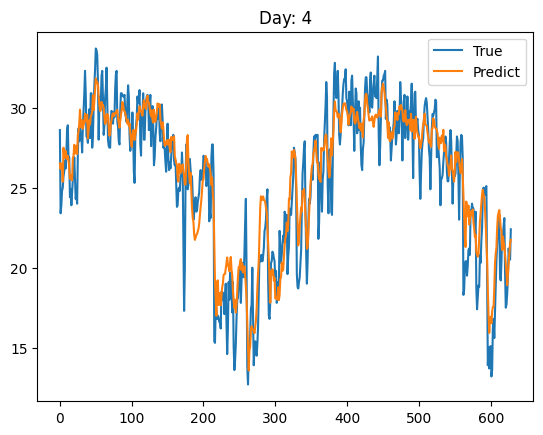

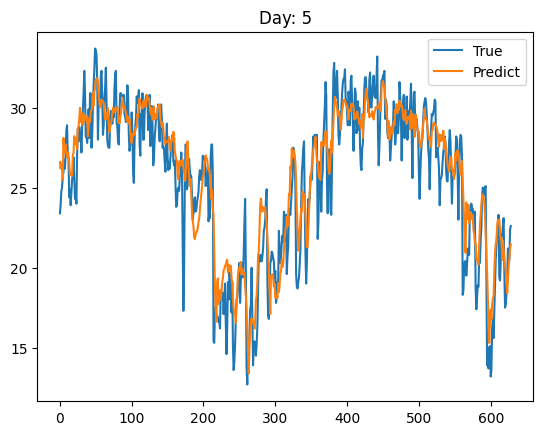

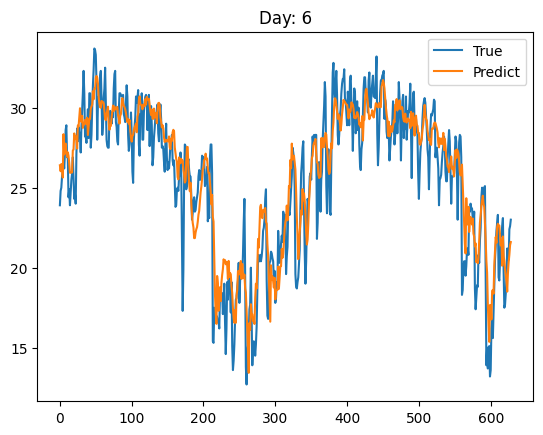

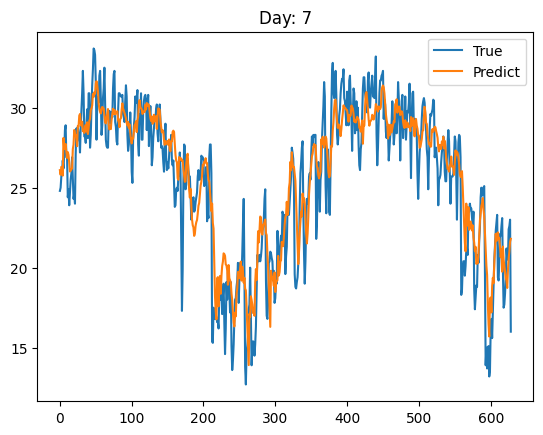

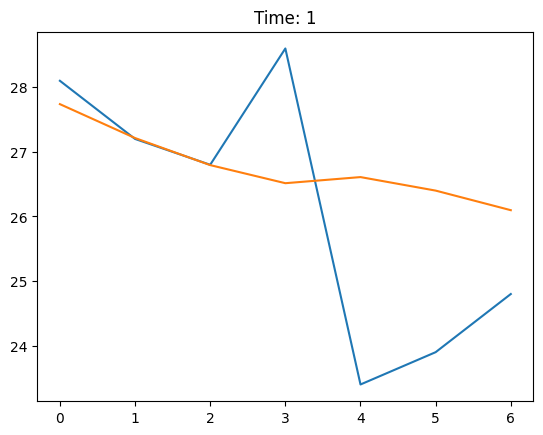

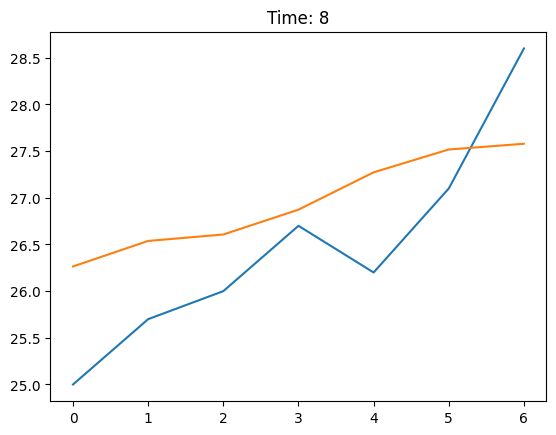

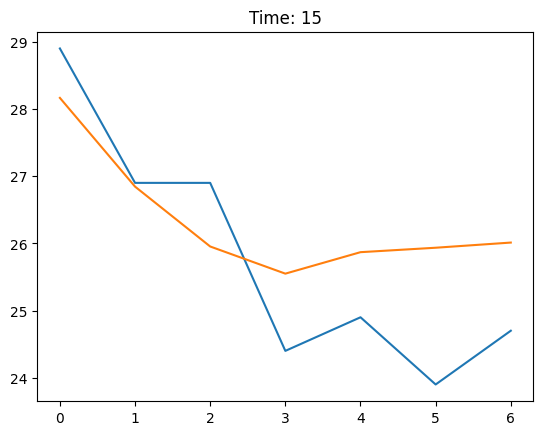

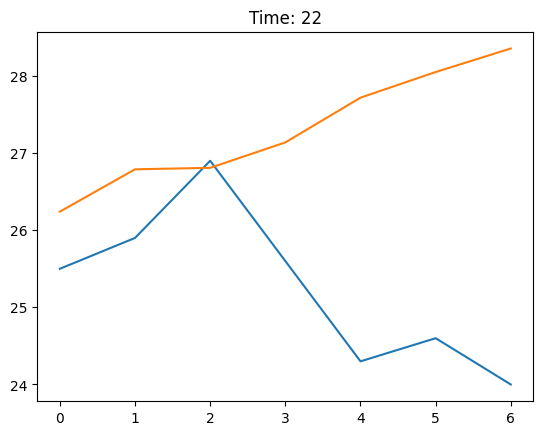

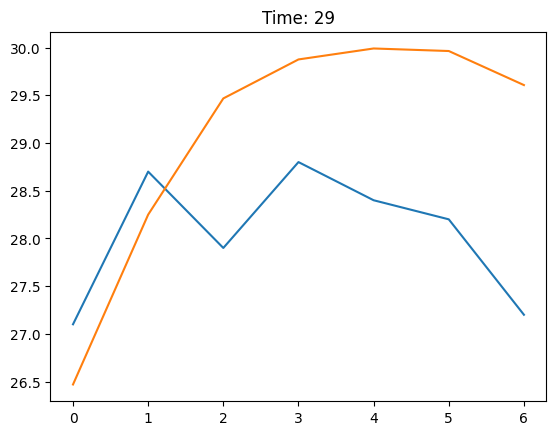

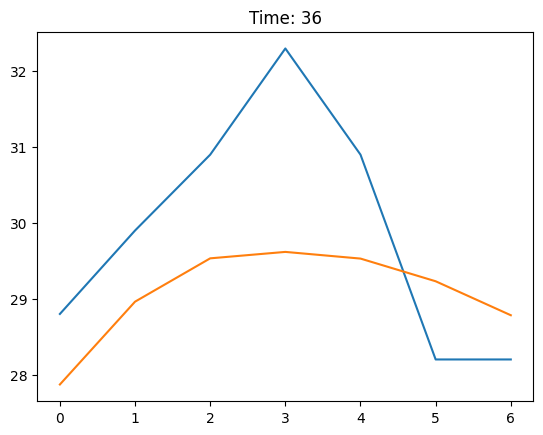

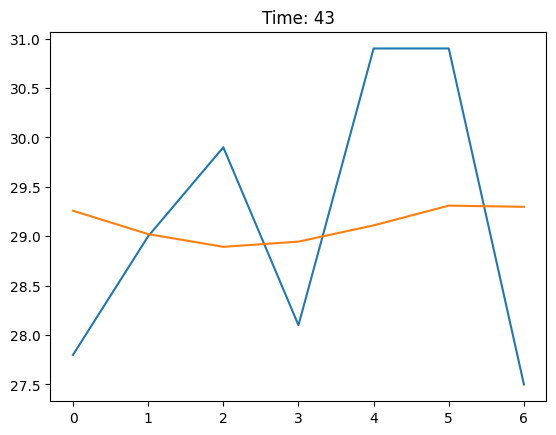

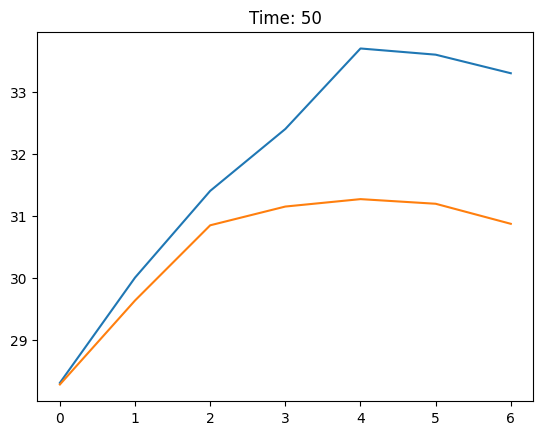

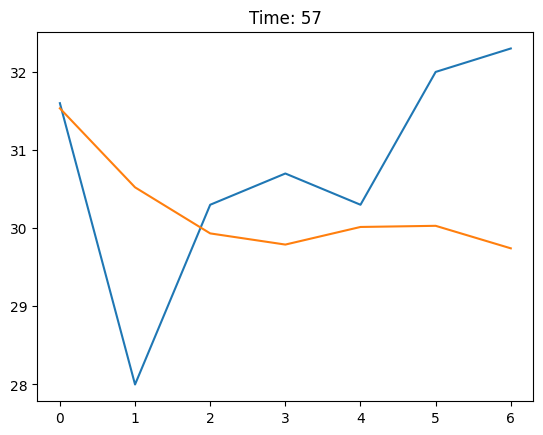

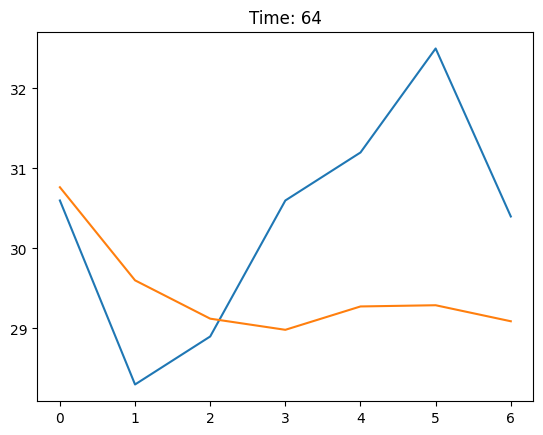

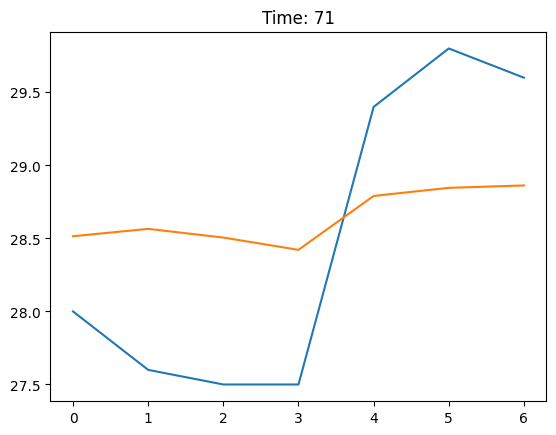

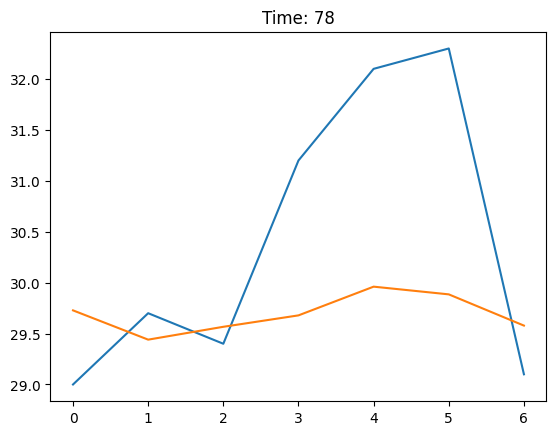

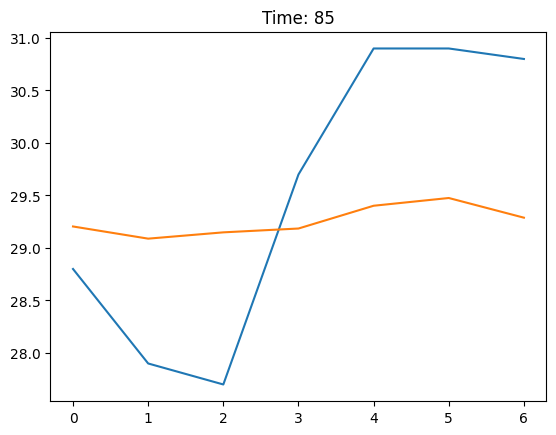

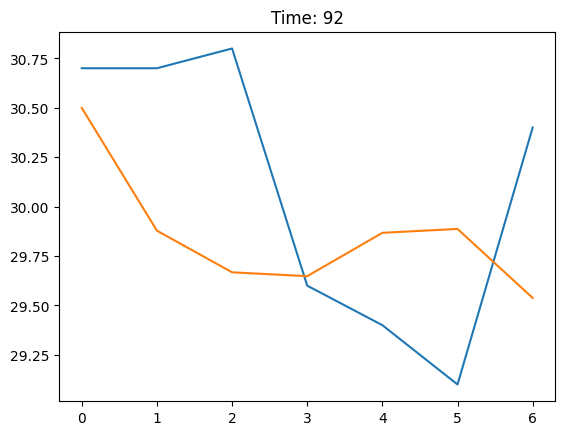

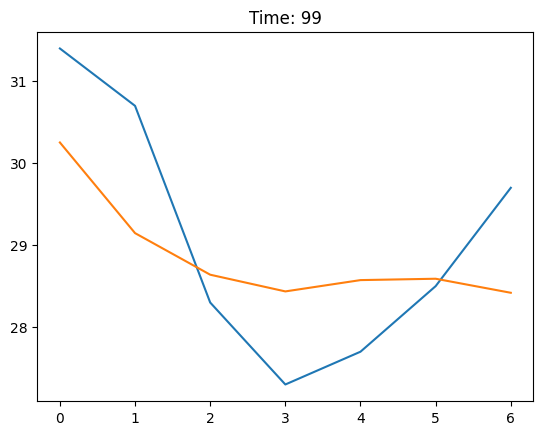

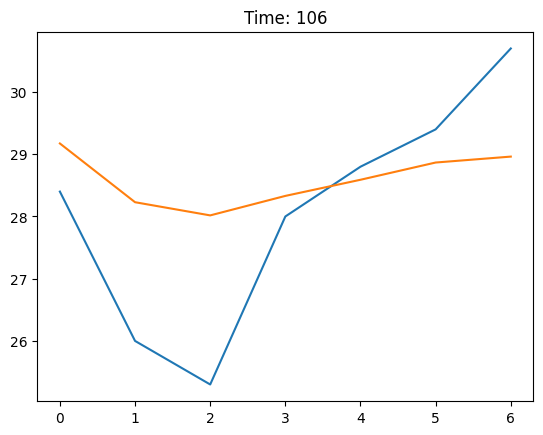

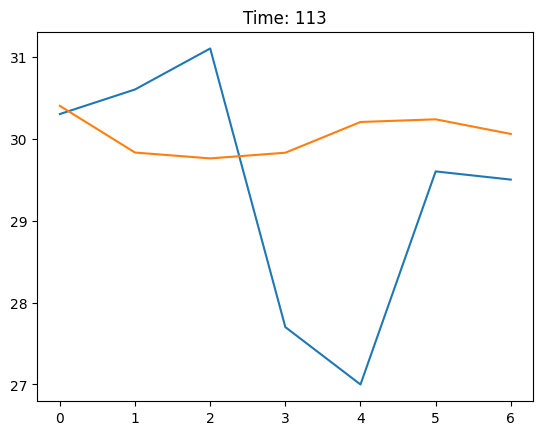

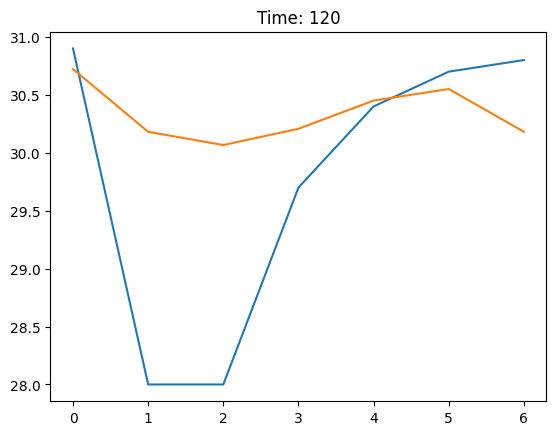

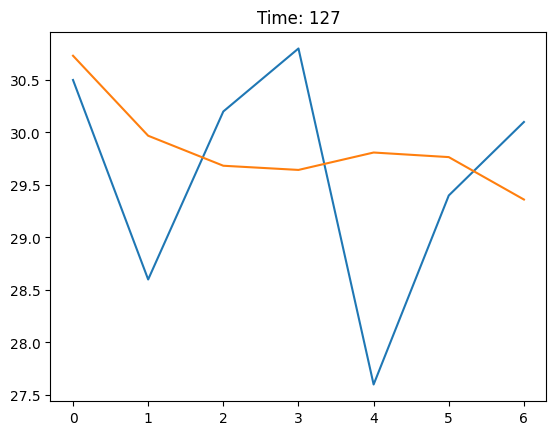

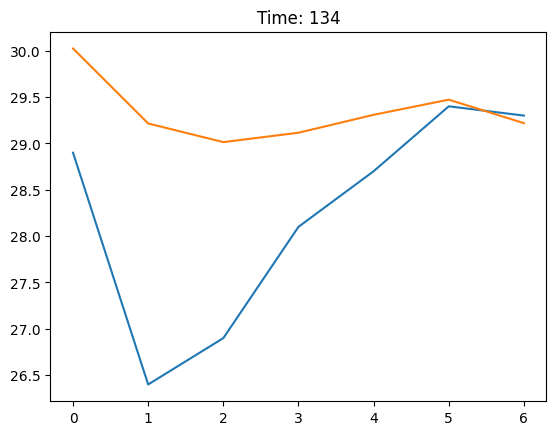

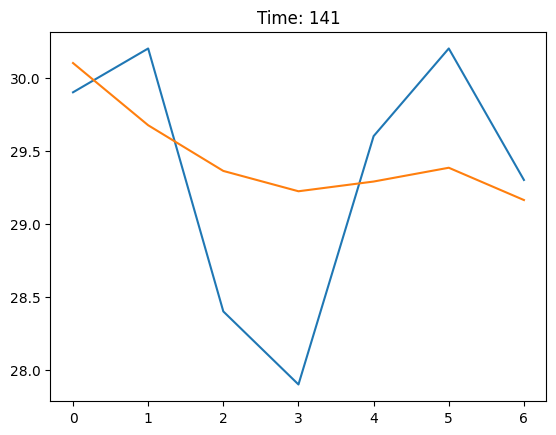

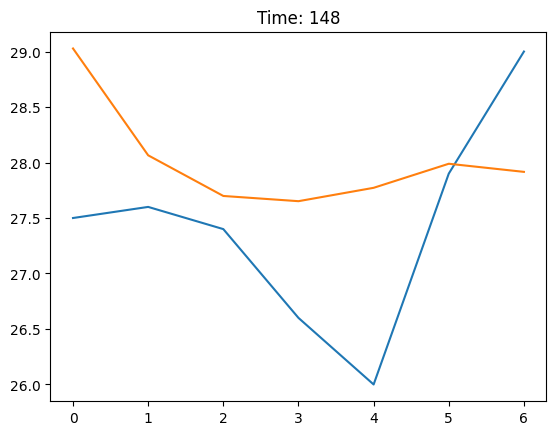

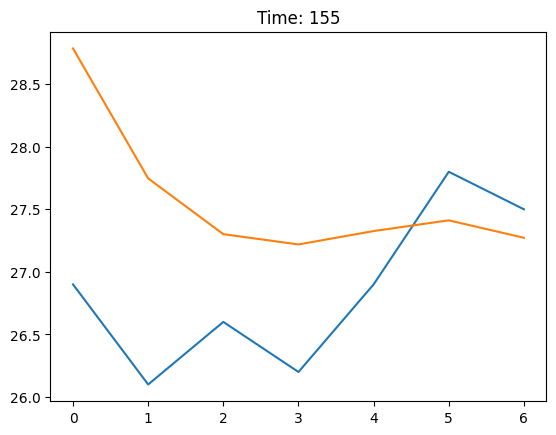

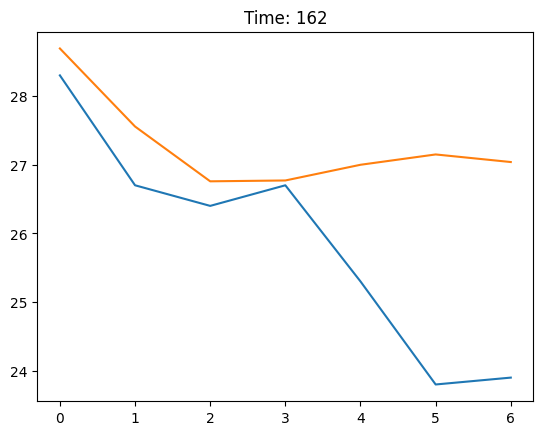

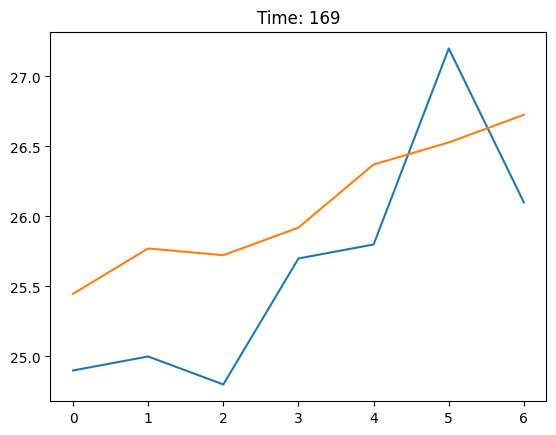

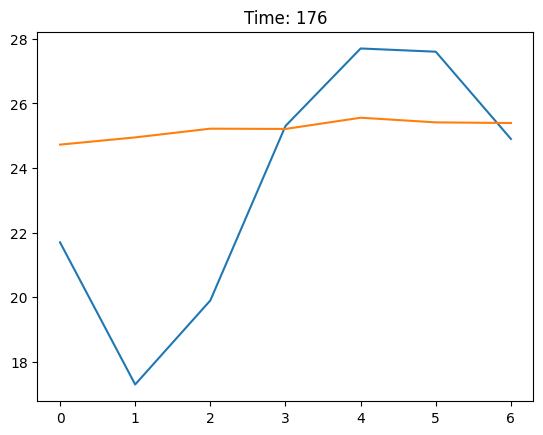

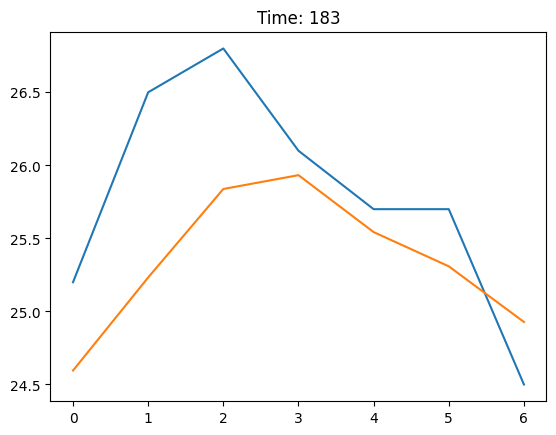

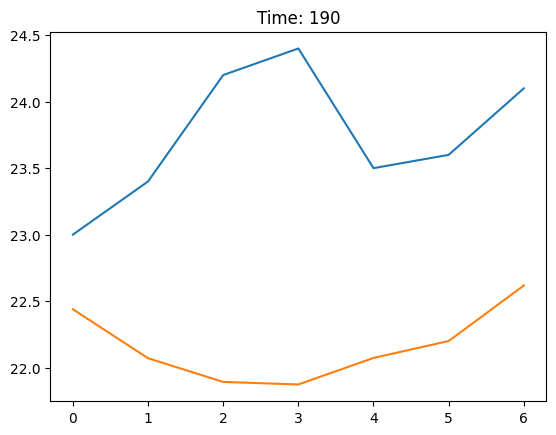

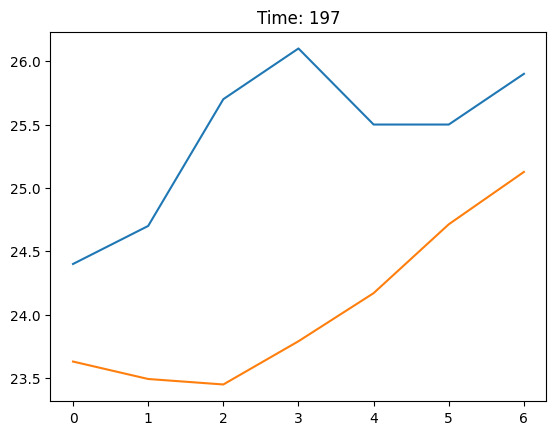

In [168]:
predict = model_recall.predict(X_test_norm)
feature = 0
predict_unnorm = unnormalize(predict, y_train.mean(), y_train.std())
y_test_unnorm = unnormalize(y_test_norm, y_train.mean(), y_train.std())
for i in range(out_steps):
    print('Day: ', i+1)
    print('MAE: ', mean_absolute_error(y_test_unnorm[:,i,feature], predict_unnorm[:,i,feature]))
    print('MSE: ', mean_squared_error(y_test_unnorm[:,i,feature], predict_unnorm[:,i,feature]))
    print('CORR: ', np.corrcoef(y_test_unnorm[:,i,feature], predict_unnorm[:,i,feature])[0,1])
for i in range(out_steps):
    plt.title('Day: ' + str(i+1))
    plt.plot(y_test_unnorm[:,i,feature])
    plt.plot(predict_unnorm[:,i,feature])
    plt.legend(['True', 'Predict'])
    plt.show()
for i in range(0, 200, out_steps):
    plt.title('Time: ' + str(i+1))
    plt.plot(y_test_unnorm[i,:,feature])
    plt.plot(predict_unnorm[i,:,feature])
    plt.show()
    

In [ ]:
model_60_recall = tf.keras.models.load_model('lstm60-ewt-7-temp-not_overfit.keras')
model_90_recall = tf.keras.models.load_model('lstm90-ewt-7-temp-not_overfit.keras')
model_180_recall = tf.keras.models.load_model('lstm180-ewt-7-temp-not_overfit.keras')
model_365_recall = tf.keras.models.load_model('lstm365-ewt-7-temp-not_overfit.keras')
model_730_recall = tf.keras.models.load_model('lstm730-ewt-7-temp-not_overfit.keras')

In [ ]:
print(model_60_recall.evaluate(X_test_norm, y_test_norm))
print(model_90_recall.evaluate(X_test_norm, y_test_norm))
print(model_180_recall.evaluate(X_test_norm, y_test_norm))
print(model_365_recall.evaluate(X_test_norm, y_test_norm))
print(model_730_recall.evaluate(X_test_norm, y_test_norm))

In [ ]:
predict_60 = model_60_recall.predict(X_test_norm)
predict_90 = model_90_recall.predict(X_test_norm)
predict_180 = model_180_recall.predict(X_test_norm)
predict_365 = model_365_recall.predict(X_test_norm)
predict_730 = model_730_recall.predict(X_test_norm)

unnormalize_60 = unnormalize(predict_60, y_train.mean(), y_train.std())
unnormalize_90 = unnormalize(predict_90, y_train.mean(), y_train.std())
unnormalize_180 = unnormalize(predict_180, y_train.mean(), y_train.std())
unnormalize_365 = unnormalize(predict_365, y_train.mean(), y_train.std())
unnormalize_730 = unnormalize(predict_730, y_train.mean(), y_train.std())

In [ ]:

data_views = []
for i in range(7):
    data_views.append([y_test_unnorm[:,i,0], unnormalize_60[:,i,0], unnormalize_90[:,i,0], unnormalize_180[:,i,0], unnormalize_365[:,i,0], unnormalize_730[:,i,0]])

# data_view_1 = [y_test_unnorm[:,0,0], unnormalize_60[:,0,0], unnormalize_90[:,0,0], unnormalize_180[:,0,0], unnormalize_365[:,0,0], unnormalize_730[:,0,0]]
# data_view_2 = [y_test_unnorm[:,1,0], unnormalize_60[:,1,0], unnormalize_90[:,1,0], unnormalize_180[:,1,0], unnormalize_365[:,1,0], unnormalize_730[:,1,0]]
# data_view_3 = [y_test_unnorm[:,2,0], unnormalize_60[:,2,0], unnormalize_90[:,2,0], unnormalize_180[:,2,0], unnormalize_365[:,2,0], unnormalize_730[:,2,0]]
# data_view_4 = [y_test_unnorm[:,3,0], unnormalize_60[:,3,0], unnormalize_90[:,3,0], unnormalize_180[:,3,0], unnormalize_365[:,3,0], unnormalize_730[:,3,0]]
# data_view_5 = [y_test_unnorm[:,4,0], unnormalize_60[:,4,0], unnormalize_90[:,4,0], unnormalize_180[:,4,0], unnormalize_365[:,4,0], unnormalize_730[:,4,0]]
# data_view_6 = [y_test_unnorm[:,5,0], unnormalize_60[:,5,0], unnormalize_90[:,5,0], unnormalize_180[:,5,0], unnormalize_365[:,5,0], unnormalize_730[:,5,0]]
# data_view_7 = [y_test_unnorm[:,6,0], unnormalize_60[:,6,0], unnormalize_90[:,6,0], unnormalize_180[:,6,0], unnormalize_365[:,6,0], unnormalize_730[:,6,0]]
pd_data_views = pd.DataFrame(data_views)


In [ ]:
labels = ['True', '60', '90', '180', '365', '730']

fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7) = plt.subplots(nrows=7, ncols=1, figsize=(6, 21))
bplot1 = ax1.boxplot(data_views[0],
                     notch=True,  # notch shape
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax1.set_title('Day 1')
bplot2 = ax2.boxplot(data_views[1],
                     notch=True,  # notch shape
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax2.set_title('Day 2')
bplot3 = ax3.boxplot(data_views[2],
                     notch=True,  # notch shape
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax3.set_title('Day 3')
bplot4 = ax4.boxplot(data_views[3],
                     notch=True,  # notch shape
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax4.set_title('Day 4')
bplot5 = ax5.boxplot(data_views[4],
                     notch=True,  # notch shape
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax5.set_title('Day 5')
bplot6 = ax6.boxplot(data_views[5],
                     notch=True,  # notch shape
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax6.set_title('Day 6')
bplot7 = ax7.boxplot(data_views[6],
                     notch=True,  # notch shape
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax7.set_title('Day 7')

# fill with colors
colors = ['pink', 'lightblue', 'lightgreen', 'lightyellow', 'lightcoral', 'lightgrey']
for bplot in (bplot1, bplot2, bplot3, bplot4, bplot5, bplot6,bplot7):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

# adding horizontal grid lines
for ax in [ax1, ax2, ax3, ax4, ax5, ax6,ax7]:
    ax.yaxis.grid(True)
    ax.set_xlabel('Lag')
    ax.set_ylabel('Observed values')

plt.show()

In [ ]:
model_recall_RF = joblib.load('model_rf-ewt-90-7.pkl')

In [ ]:
predictions = model_recall_RF.predict(X_test_norm.reshape(X_test_norm.shape[0], X_test_norm.shape[1]*X_test_norm.shape[2]))
predictions = predictions.reshape(predictions.shape[0], out_steps, num_features)

predict_unnorm = unnormalize(predictions, y_train.mean(), y_train.std())

In [ ]:
data_view_rf = [y_test_unnorm[:,0,0], predict_unnorm[:,0,0], data_views[1][1], data_views[2][1], data_views[3][1], data_views[4][1], data_views[5][1], data_views[6][1]]
plt.boxplot(data_view_rf)

In [ ]:
X_test_norm = X_double_test_norm
y_test_norm = y_double_test_norm
predict = model_recall.predict(X_test_norm)
feature = 0
predict_unnorm = unnormalize(predict, y_train.mean(), y_train.std())
y_test_unnorm = unnormalize(y_test_norm, y_train.mean(), y_train.std())
for i in range(out_steps):
    print('Day: ', i+1)
    print('MAE: ', mean_absolute_error(y_test_unnorm[:,i,feature], predict_unnorm[:,i,feature]))
    print('MSE: ', mean_squared_error(y_test_unnorm[:,i,feature], predict_unnorm[:,i,feature]))
    print('CORR: ', np.corrcoef(y_test_unnorm[:,i,feature], predict_unnorm[:,i,feature])[0,1])
for i in range(out_steps):
    plt.title('Day: ' + str(i+1))
    plt.plot(y_test_unnorm[:,i,feature])
    plt.plot(predict_unnorm[:,i,feature])
    plt.legend(['True', 'Predict'])
    plt.show()
for i in range(0, 200, out_steps):
    plt.title('Time: ' + str(i+1))
    plt.plot(y_test_unnorm[i,:,feature])
    plt.plot(predict_unnorm[i,:,feature])
    plt.show()

In [ ]:
predict = model.predict(X_test_norm)
predict_unnorm = unnormalize(predict, y_train.mean(), y_train.std())
y_test_unnorm = unnormalize(y_test_norm, y_train.mean(), y_train.std())
for i in range(14):
    print('Day: ', i+1)
    print('MAE: ', mean_absolute_error(y_test_unnorm[:,i,0], predict_unnorm[:,i,0]))
    print('MSE: ', mean_squared_error(y_test_unnorm[:,i,0], predict_unnorm[:,i,0]))
    print('CORR: ', np.corrcoef(y_test_unnorm[:,i,0], predict_unnorm[:,i,0])[0,1])
for i in range(14):
    plt.title('Day: ' + str(i+1))
    plt.plot(y_test_unnorm[:,i,0])
    plt.plot(predict_unnorm[:,i,0])
    plt.legend(['True', 'Predict'])
    plt.show()
for i in range(0, 200, 14):
    plt.title('Time: ' + str(i+1))
    plt.plot(y_test_unnorm[i,:,0])
    plt.plot(predict_unnorm[i,:,0])
    plt.show()